In [1]:
%matplotlib inline

In [2]:
import math 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec

import gurobipy as gp
from gurobipy import GRB

from tqdm.notebook import trange

In [3]:
plt.style.use('scientific')

In [4]:
from rsnn.spike_train.generator import PeriodicSpikeTrainGenerator
from rsnn.spike_train.spike_train import SpikeTrain
from rsnn.spike_train.periodic_spike_train import MultiChannelPeriodicSpikeTrain
from rsnn.rsnn.neuron import Neuron
from rsnn.optim.gmp import observation_block_forward, equality_block
from rsnn.optim.nuv import binary_prior, box_prior, pnorm_prior, laplace_prior, half_space_prior, plain_prior
from rsnn.optim.cost import box_cost, half_space_cost, plain_cost, laplace_cost, pnorm_cost
from rsnn.spike_train.measure import single_channel_correlation
from rsnn.utils.utils import cyclic_after, cyclic_before, cyclic_neighborhood

/Users/haguettaz/Documents/RSNN/src/rsnn/spike_train/generator.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [5]:
rng = np.random.default_rng()

# Supervised Learning for Spiking Neurons

In [22]:
num_inputs = 250 # number of synapses
delays = rng.uniform(1.0, 30.0, num_inputs)
synapse_decay, soma_decay = 4, 5
firing_threshold = 1.0
wmin, wmax = -0.1, 0.1

period = 100.0
firing_rate, rel_refractory_period, abs_refractory_period = 0.1, 5.0, 5.0
refractory_weight = 1

In [23]:
times = np.linspace(0, period, 10000)

In [24]:
def input_spike_resp(t):
    tmax = (math.log(synapse_decay) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_decay)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_decay))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_decay))
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_decay))

def input_spike_resp_deriv(t):
    tmax = (math.log(synapse_decay) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_decay)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_decay))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / synapse_decay) / synapse_decay - np.exp(-t / soma_decay) / soma_decay)
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / synapse_decay) / synapse_decay - np.exp(-t / soma_decay) / soma_decay)

def refractory_spike_resp(t):
    if isinstance(t, np.ndarray):
        z = -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)
        z[t <= abs_refractory_period] = -np.inf
        z[t <= 0] = 0.0
        return z
    
    if t <= 0:
        return 0.0
    
    if t <= abs_refractory_period:
        return -np.inf
    
    return -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)

In [25]:
def potential(t, delays, weights):
    y = np.array([
        np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None]) % period), axis=0) for k in range(num_inputs)
    ])
    return weights@y

In [26]:
def potential_deriv(t, delays, weights):
    y = np.array([
        np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None]) % period), axis=0) for k in range(num_inputs)
    ])
    return weights@y

In [27]:
def threshold(t):
    return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None]) % period), axis=0)

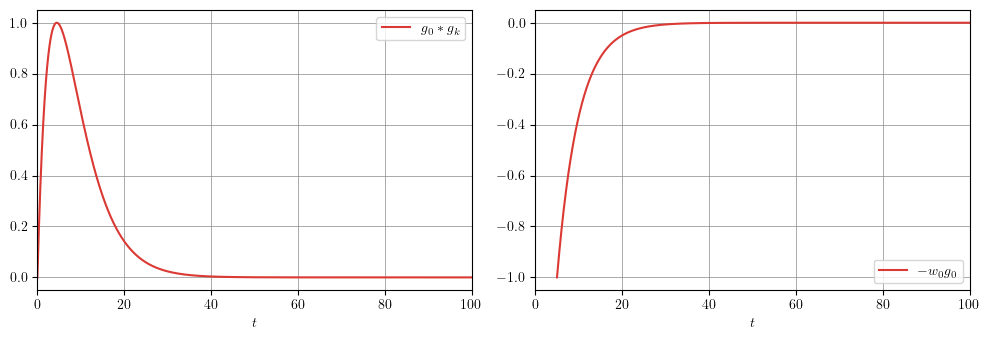

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].plot(times, input_spike_resp(times), c="C1", label=r"$g_0 * g_k$")
axes[1].plot(times, refractory_spike_resp(times), c="C1", label=r"$-w_0 g_0$")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel(r"$t$")
axes[0].set_xlim(0, period)
axes[1].set_xlabel(r"$t$")
axes[1].set_xlim(0, period)
fig.tight_layout()

In [29]:
spike_train_generator = PeriodicSpikeTrainGenerator(firing_rate, abs_refractory_period, rel_refractory_period)

In [30]:
input_spike_trains = spike_train_generator.rand(period, num_inputs)
#input_spike_train = spike_train_generator.rand(period)
#input_spike_trains = MultiChannelPeriodicSpikeTrain(
#    period, 
#    num_inputs,
#    [input_spike_train.firing_times]*num_inputs
#)
target_spike_train = spike_train_generator.rand(period)

Multi-channel periodic spike train sampling:   0%|          | 0/250 [00:00<?, ?it/s]

In [31]:
num_spikes = np.array([spike_train.num_spikes for spike_train in input_spike_trains.spike_trains])

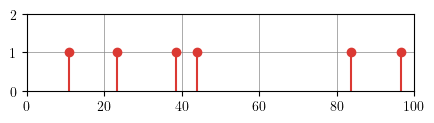

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.stem(target_spike_train.firing_times, np.ones_like(target_spike_train.firing_times), basefmt=" ", markerfmt="C1o", linefmt="C1-")
ax.set_xlim(0, period)
ax.set_ylim(0, 2)
plt.show()

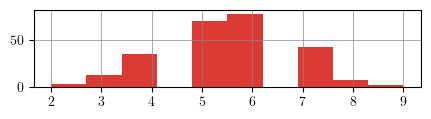

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.hist(num_spikes, color="C1")
plt.show()

# Computing Weights

In [34]:
def compute_template(max_level, firing_region, min_slope, time_step):
    yf, ys, yl = [], [], []
    zf, zs, zl = [], [], []
    
    # equality at firing times
    for t in target_spike_train.firing_times:
        yf.append(
            np.array(
                [np.sum(input_spike_resp(
                    (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                ))
                for k in range(num_inputs)] 
            )
        )
        zf.append(firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    # smaller than the firing threshold everywhere (except during the absolute refractory period)
    for t in cyclic_after(target_spike_train.firing_times, period, abs_refractory_period, time_step, True):
        yl.append(
                np.array(
                    [np.sum(input_spike_resp(
                        (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                    ))
                    for k in range(num_inputs)] 
                )
            )
        zl.append(firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    # smaller than the maximum level not close to firing (except during the absolute refractory period)
    for t in cyclic_neighborhood(target_spike_train.firing_times, period, firing_region, abs_refractory_period, time_step, True):
        yl.append(
                np.array(
                    [np.sum(input_spike_resp(
                        (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                    ))
                    for k in range(num_inputs)] 
                )
            )
        zl.append(max_level - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    # slope larger than the minimum slope close to firing
    for t in cyclic_neighborhood(target_spike_train.firing_times, period, firing_region, firing_region, time_step):
        ys.append(
            np.array(
                [np.sum(input_spike_resp_deriv(
                    (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                ))
                for k in range(num_inputs)] 
            )
        )
        zs.append(min_slope)
        
    return np.vstack(yf), np.array(zf), np.vstack(yl), np.array(zl), np.vstack(ys), np.array(zs) 

In [35]:
delays = rng.uniform(1.0, 20.0, num_inputs)
yf, zf, yl, zl, ys, zs = compute_template(firing_threshold - 0.5, 1.0, 0.5, 0.2)

## Bounded Weights

In [36]:
model = gp.Model("memory")

# Create variables
wgp = model.addMVar(shape=num_inputs, lb=wmin, ub=wmax, name="weights")

# Set objective
objective = 0.0
model.setObjective(objective, GRB.MINIMIZE)

# Add constraints
model.addConstr(yf @ wgp == zf, name="firing")
model.addConstr(yl @ wgp <= zl, name="max_level")
model.addConstr(ys @ wgp >= zs, name="min_slope")

# Optimize model
model.optimize();

model.status == 2

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 739 rows, 250 columns and 184750 nonzeros
Model fingerprint: 0x38c7170a
Coefficient statistics:
  Matrix range     [2e-07, 2e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [5e-01, 2e+00]
Presolve removed 323 rows and 0 columns
Presolve time: 0.02s
Presolved: 416 rows, 250 columns, 104000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.340821e+02   0.000000e+00      0s
     160    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 160 iterations and 0.04 seconds (0.07 work units)
Optimal objective  0.000000000e+00


True

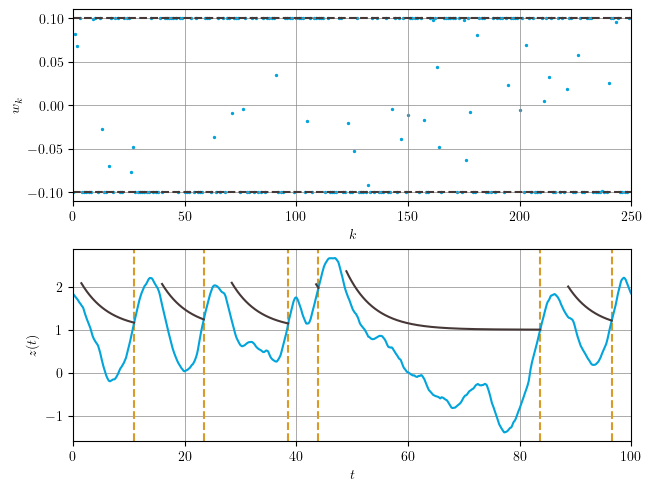

In [37]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wgp.X, s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C0")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C0")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C4")
_ = axes_template[1].plot(times, potential(times, delays, wgp.X), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times), c="C0")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

## Bounded Weights with L2 Regularization

In [39]:
model = gp.Model("memory")

# Create variables
wgp = model.addMVar(shape=num_inputs, lb=wmin, ub=wmax, name="weights")

# Set objective
objective = wgp@wgp
model.setObjective(objective, GRB.MINIMIZE)

# Add constraints
model.addConstr(yf @ wgp == zf, name="firing")
model.addConstr(yl @ wgp <= zl, name="max_level")
model.addConstr(ys @ wgp >= zs, name="min_slope")

# Optimize model
model.optimize();

model.status == 2

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 739 rows, 250 columns and 184750 nonzeros
Model fingerprint: 0x51bf7652
Model has 250 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-07, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [5e-01, 2e+00]
Presolve removed 323 rows and 0 columns
Presolve time: 0.02s
Presolved: 416 rows, 250 columns, 104000 nonzeros
Presolved model has 250 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.632e+04
 Factor NZ  : 8.674e+04 (roughly 1 MB of memory)
 Factor Ops : 2.408e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.25015132e+07 -6.2626

True

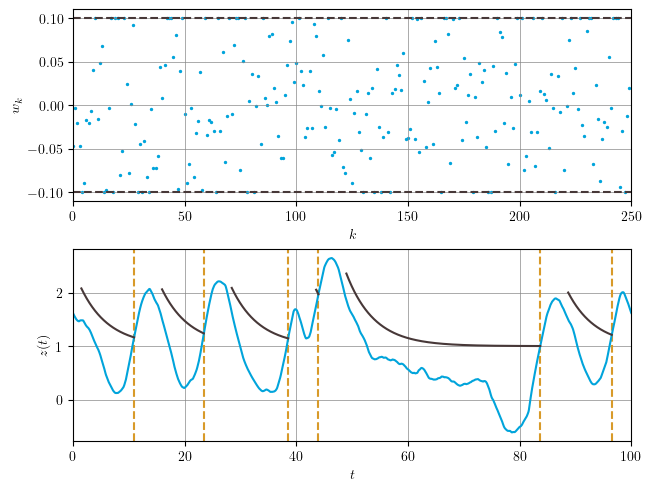

In [41]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wgp.X, s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C0")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C0")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C4")
_ = axes_template[1].plot(times, potential(times, delays, wgp.X), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times), c="C0")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

## Bounded Weights with L1 Regularization

In [59]:
model = gp.Model("memory")

# Create variables
tgp = model.addMVar(shape=1)
ygp = model.addMVar(shape=num_inputs)
wgp = model.addMVar(shape=num_inputs, lb=wmin, ub=wmax, name="weights")

# Set objective
model.addConstr(ygp@np.ones(num_inputs) == tgp)
model.addConstr(-wgp <= ygp)
model.addConstr(wgp <= ygp)

objective = tgp
model.setObjective(objective, GRB.MINIMIZE)

# Add constraints
model.addConstr(yf @ wgp == zf, name="firing")
model.addConstr(yl @ wgp <= zl, name="max_level")
model.addConstr(ys @ wgp >= zs, name="min_slope")

# Optimize model
model.optimize();

model.status == 2

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1246 rows, 501 columns and 187501 nonzeros
Model fingerprint: 0x06ba91db
Coefficient statistics:
  Matrix range     [2e-07, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [5e-01, 2e+00]
Presolve removed 330 rows and 1 columns
Presolve time: 0.04s
Presolved: 916 rows, 500 columns, 105000 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.946e+05
 Factor NZ  : 3.245e+05 (roughly 3 MB of memory)
 Factor Ops : 1.402e+08 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.10 seconds (0.07 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective     

True

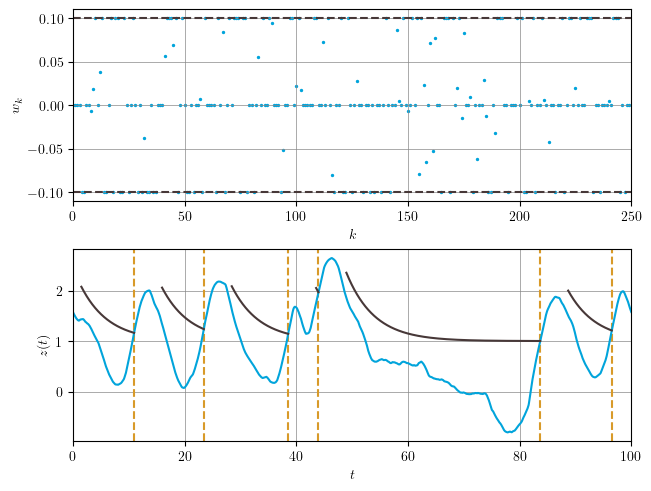

In [61]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wgp.X, s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C0")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C0")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C4")
_ = axes_template[1].plot(times, potential(times, delays, wgp.X), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times), c="C0")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

## Discrete Weights

In [63]:
model = gp.Model("memory")

# Create variables
wgp = model.addMVar(shape=num_inputs, lb=10*wmin, ub=10*wmax, vtype=GRB.INTEGER, name="weights")

# Set objective
objective = (yf @ wgp - 10*zf)@(yf @ wgp - 10*zf)
model.setObjective(objective, GRB.MINIMIZE)

# Add constraints
model.addConstr(yl @ wgp <= 10*zl, name="max_level")
model.addConstr(ys @ wgp >= 10*zs, name="min_slope")

# Optimize model
model.optimize();

model.status == 2

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 733 rows, 250 columns and 183250 nonzeros
Model fingerprint: 0x05900d94
Model has 31375 quadratic objective terms
Variable types: 0 continuous, 250 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-07, 2e+00]
  Objective range  [2e+01, 2e+02]
  QObjective range [2e-03, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 2e+01]
Found heuristic solution: objective 20678.104988
Presolve removed 323 rows and 0 columns
Presolve time: 0.06s
Presolved: 410 rows, 250 columns, 102500 nonzeros
Presolved model has 31375 quadratic objective terms
Variable types: 0 continuous, 250 integer (0 binary)
Found heuristic solution: objective 227.8163923

Root relaxation: objective -4.547474e-13, 1739 iterations, 0.05 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objecti

False

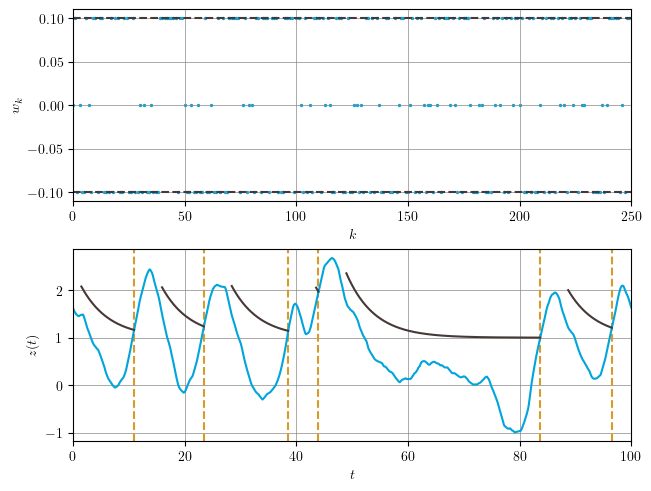

In [64]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wgp.X/10, s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C0")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C0")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C4")
_ = axes_template[1].plot(times, potential(times, delays, wgp.X/10), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times), c="C0")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")